# Autoregressive model using OLS

In this notebook we will use Ordinary Least Square (OLS) to fit a linear model to time series data. OLS is a supervised learning approach and is not designed specifically with time series in mind.  However, it is easy to adapt and use with autoregressive data.  There are two caveats 

<div class="alert alert-success">
    
1. Unlike purpose built time series models such as ARIMA we need to preprocess the data beforehand.

2. Forecasting **h-steps** ahead is more involved than other methods.
</div>

 
However, OLS itself is very simple to use and the procedures we develop to solve 1 and 2 are exactly what we need to work with Feedforward Neural Networks and Recurrent Neural Networks which we will cover later.

---
**LEARNING OBJECTIVES**

* Mechanics of fitting time series data to an OLS autoregressive model
* Generate h-step forecasts using an iterative approach
* Generate h-step forecast using a direct modelling approach
---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided for this work.  The implementation of Ordinary Least Squares Regression that we are going to use is in `statsmodels`.  You should be using at least version `0.11.1`

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sm.__version__

'0.11.1'

The `statsmodels` package has a class for OLS that we are going to use.

```python 
statsmodels.regression.linear_model.OLS 
```

In [2]:
from statsmodels.regression.linear_model import OLS

## 2. AR OLS: The forecasting process

1. Select $l$ the number of autoregressive lags and forecast horizon $h$
2. Preprocess the data into tabular (supervised learning) form [[$lag_1, lag_2, ... lag_l$], [$y_t$]]
3. Fit the OLS model to the tabular data
4. Iteratively forecast 1-step ahead gradually replacing ground truth observations with predictions.


### 2.1 Synthetic data without noise

Given the extra complexities of forecasting using OLS we will use simple synthetic data before exploring real healthcare data. The synthetic data we wil use is a cosine.  

In [3]:
t = np.arange(200)
ts_data = np.cos(0.2 * t)

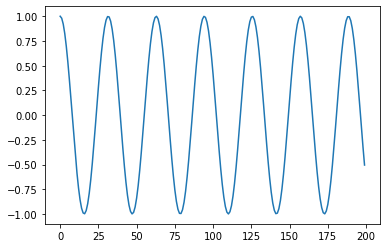

In [4]:
plt.plot(ts_data);

In [5]:
ts_data[:10]

array([ 1.        ,  0.98006658,  0.92106099,  0.82533561,  0.69670671,
        0.54030231,  0.36235775,  0.16996714, -0.02919952, -0.22720209])

## 2.2. Preprocess the time series into tabular autoregressive form

An autoregressive model consists of $l$ lags of the time series. 

An easy way to think about the form of the data for a autoregressive OLS model is as a table of variables.  The first $l$ columns are the lags (the independent predictor variables) and the final column is $y$ at time $t$ ($y_t$) that is, the target/dependent variable.  

We there need to manipulate the time series so that is now in that format.  More precisely for each row we need: 

**A vector presenting the lags at time t**
* $X_t = $ [$lag_{t-l}, ... lag_{t-2}, lag_{t-1}$]

**A scalar value representing y at time t:**
* $y_t$

For training we need a vector of rows ($X_t$) and vector of target $y_t$. e.g.

```python
X_train = [X_1, X_2, X_3, ...,  X_t]

y_train = [y_1, y_2, y_3, ..., y_t]
```
---

The function `sliding_window` illustrates how to preprocess time series data into tabular form  in python.

In [6]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.asarray(tabular_y).reshape(-1, 1)

In [7]:
#Let's do a train test split first
train = ts_data[:175]
test = ts_data[175:]

#preprocess time series training and test sets
X_train, y_train = sliding_window(train, window_size=2)
X_test, y_test = sliding_window(test, window_size=2)

In [8]:
print(X_train.shape)
print(y_train.shape)

(172, 2)
(172, 1)


The preprocessing included 2 lags.  So let's have a look at how the first elements in `X_train` and `y_train` compare to the first three elements of `ts_data`

In [9]:
print(f'ts_data[:3]: {ts_data[:3]}')
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

ts_data[:3]: [1.         0.98006658 0.92106099]
X_train[0]: [1.         0.98006658]
y_train[0]: [0.92106099]


Just to prove this is work let's manually slide out window of lag size 2 along `ts_data` to see how it compares with the next element in `X_train` and `y_train`

In [10]:
print(f'ts_data[1:4]: {ts_data[1:4]}')
print(f'X_train[1]: {X_train[1]}')
print(f'y_train[1]: {y_train[1]}')

ts_data[1:4]: [0.98006658 0.92106099 0.82533561]
X_train[1]: [0.98006658 0.92106099]
y_train[1]: [0.82533561]


<div class="alert alert-warning">
    
Just to be absolutely clear what we are doing let's convert the numpy arrays to a **pandas.DataFrame**.  In this format you should be able to see why the an OLS model
can be used for autoregression in a time series.
</div>



In [11]:
tabular_form = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
columns = [f'lag_{i}' for i in range(len(X_train[0]), 0, -1)]
columns.append('y_t')
tabular_form.columns = columns
tabular_form.head()

,lag_2,lag_1,y_t
0,1.000000,0.980067,0.921061
1,0.980067,0.921061,0.825336
2,0.921061,0.825336,0.696707
3,0.825336,0.696707,0.540302
4,0.696707,0.540302,0.362358


## 2.3 Fit the preprocessed data to the OLS model

After preprocessing the data, fitting the data is relatively straightforward.  We create an instance of `OLS` passing in the training data and call the `.fit()` method.  The method fit returns a `RegressionResults` object that we use for prediction.  We can called the `.summary()` method to see the fitted model.

In [12]:
X_train = sm.add_constant(X_train)
model = OLS(endog=y_train, exog=X_train).fit()

#see the regression results (not the adj. R squared!)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.115e+31
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:20:44   Log-Likelihood:                 5582.4
No. Observations:                 172   AIC:                        -1.116e+04
Df Residuals:                     169   BIC:                        -1.115e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.336e-16    1.5e-16      0.891      0.374   -1.62e-16     4.3e-16
x1            -1.0000   1.06e-15  -9.39e+14      0.000      -1.000      -1.000
x2             1.9601   1.06e-15   1.84e+15      0.000       1.960       1.960
==============================================================================
Omnibus:                       15.705   Durbin-Watson:                   2.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.209
Skew:                          -0.003   Prob(JB):                     2.79e-12
Kurtosis:                       5.725   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2.4 Forecasting 1 step ahead

To forecast 1-step ahead we use the `RegressionResults` method `.predict(exog)`.  For example if we wanted to forecast the first y observation in the test set.

In [13]:
X_test = sm.add_constant(X_test)
pred = model.predict(exog=X_test[0])[0]
print(f'1-step forecast: {pred}')
print(f'ground truth value: {y_test[0][0]}')

1-step forecast: -0.6656134553337539
ground truth value: -0.6656134553337595


An alternative way to call predict is to use `.get_prediction(exog)` to get a `PredictionResults` object.  This has the nice method `.summary_frame(alpha=0.05)` that can be used to get a dataframe with 

In [14]:
results = model.get_prediction(exog=X_test[0])
results.summary_frame(alpha=0.2)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-0.665613,2.651639e-16,-0.665613,-0.665613,-0.665613,-0.665613


## 2.4 Forecast h periods ahead using the iterative method.

**We have trained our `OLS` model to predict 1-step** ahead by regressing the previous two observations in the time series.  When forecasting 2 or more steps ahead we still only have two ground truth observations ($lag_1$ and $lag_2$). This means that when forecasting h-steps ahead we need to do this in a loop where we iteratively replace our ground truth observations with our predictions.

There's an easy way to do this in python using the `np.roll(a, shift)` function.  That shifts everything in the array down by `shift`.  The function is **circular** so the value in element 0 is moved to be the final value in the array.

In [ ]:
y_pred = 999

In [ ]:
current_X = np.array([1, 2, 3, 4])
current_X = np.roll(current_X, shift=-1)
current_X

In [ ]:
current_X = np.array([1, 2, 3, 4])
current_X = np.roll(current_X, shift=-1)
current_X[-1] = y_pred
current_X


In [ ]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X)[0]
        y_preds.append(y_pred)

        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [ ]:
H = 5
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
print(f'Iterative forecast: {y_preds}')
print(f'Ground truth y: {y_test[:H].T[0]}')

#### Adding some noise

To make this a bit more interesting we will add some normally distributed noise to the synthetic time series.

In [ ]:
#set the random seed so that we all get the same results
np.random.seed(12)
t = np.arange(200)
ts_data = np.cos(0.2 * t)
noise = np.random.normal(loc=0.0, scale=0.3, size=200)
ts_data = ts_data + noise
plt.plot(ts_data);

In [ ]:
def select_model_via_aic(train, test, window_sizes):  
    best = {'aic':np.Inf,
            'model': None,
            'ws': None}
    
    for ws in window_sizes:
    
        #preprocess time series training and test sets
        X_train, y_train = sliding_window(train, window_size=ws)
        X_test, y_test = sliding_window(test, window_size=ws)

        X_train = sm.add_constant(X_train)
        model = OLS(endog=y_train, exog=X_train).fit()
        
        if model.aic < best['aic']:
            print(ws, model.aic)
            best['aic'] = model.aic
            best['model'] = model
            best['ws'] = ws
            
    return best

In [ ]:
ws = [i for i in range(2, 26, 2)]
print(f'Window sizes to test {ws}')

#train test split 150 and 50
train, test = ts_data[:150], ts_data[150:]

best = select_model_via_aic(train, test, ws)
print(f"lags included: {best['ws']}")

In [ ]:
plt.plot(ts_data[best['ws']+1:], label='ground truth')
plt.plot(best['model'].fittedvalues, label='AR OLS fitted')
plt.legend();

In [ ]:
#setup test data
ws = best['ws']

#preprocess time series training and test sets
X_train, y_train = sliding_window(train, window_size=ws)
X_test, y_test = sliding_window(test, window_size=ws)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = OLS(endog=y_train, exog=X_train).fit()

#make iterative predictions
H = len(y_test)
y_preds_iter = autoregressive_iterative_forecast(model, X_test[0], h=H)

#plot
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

##  The direct h-step forecasting method.

In the direct method to forecast h-steps ahead we have **$h$ forecasting models**.  Each model provides a single point forecast from a step ahead.  In the example here, y_test is of length 31 periods.  The direct method requires 31 OLS models to make its prediction!


Recall the `sliding_window` function.  We ignored an optional parameter `horizon` in the iterative example.  By default `horizon=1` i.e. the function returns target values that are only a single period ahead.  We can vary the step size by increasing the value of horizon.  

Let's start by assigning `horizon` the value 2.

In [ ]:
# creating the X and y training data
X_train, y_train = sliding_window(train, window_size=2, horizon=2)

In [ ]:
#print the first 5 values in the original time series.  
#Note that y_train[0] is 2 steps ahead of X_train[0]
print(f'ts_data[:5]: {ts_data[:5]}')
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

If we assign `horizon` the value 3 we get the same behaviour, but `y_train[0]` is now 3 steps ahead of `X_train[0]`

In [ ]:
X_train, y_train = sliding_window(train, window_size=2, horizon=3)
print(f'ts_data[:5]: {ts_data[:5]}')
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

**Training multiple models**

For OLS it is simple and quick to train the 31 models.  

1. Create a for loop and set it to iterate 31 times. 
2. In each loop call `sliding_window` setting `horizon` to the iteration number + 1
3. Train the model and save in a list.

In [ ]:
models = []
horizon = 31

for h in range(horizon):
    X_train, y_train = sliding_window(train, window_size=18, horizon=h+1)
    X_train = sm.add_constant(X_train)
    model_h = OLS(endog=y_train, exog=X_train).fit() 
    models.append(model_h)

We now create the `direct_forecast` function.  This is just a for loop to call the `.predict(exog)` method of each model.  Remember that the input to each model is **same** i.e. exog which in our case will be `X_test[0]`

In [ ]:
def direct_forecast(models, exog):
    '''
    h-step forecast for an autoregressive 
    model using the direct prediction method.
    
    Each model contained in @models has been trained
    to predict a unique number of steps ahead. 
    Each model forecasts and the results are 
    combined in an ordered array and returned.
    
    Parameters:
    ------
    models: list
        direct models each has has a .predict(exog) 
        interface
        
    exog: array-like
        initial vector of lagged values (X)
        
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    preds = []
    for model_h in models:
        pred_h = model_h.predict(exog=exog)
        preds.append(pred_h)
    
    return np.array(preds)

In [ ]:
#for clarity let's recreate the X and y test data
X_test, y_test = sliding_window(test, window_size=18)
X_test = sm.add_constant(X_test)

#make the direct forecast
y_preds_direct = direct_forecast(models, X_test[0])

In [ ]:
#plot the direct forecast against the test data
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

Like the iterative method the direct method looks a close match to the ground truth test set!  Let's plot all three datasets on the same chart and then take a look at the **RMSE** of each method.

In [ ]:
#plot iterative and direct
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
#iterative forecasting rmse
rmse(y_test, y_preds_iter.reshape(-1, 1))[0]

In [ ]:
#direct method
rmse(y_test, y_preds_direct)[0]

In this particular example (and holdout set) the direct method out performed the iterative method. You should not assume this is always the case!